In [53]:
#@title Import

import torch
import math
import numpy as np
from typing import Optional
import scipy.interpolate

In [54]:
#@title Utilities

def is_same_tensor(result: torch.Tensor,
                   ref: torch.Tensor,
                   tol: Optional[float]=None) -> bool:
  """
  Check if two tensors are the same.

  Args:
    result: Results by your code.
    ref: Ground truth result.

  Return:
    Whether result and ref are the same.
  """
  if (not isinstance(result, torch.Tensor) or
      not isinstance(ref, torch.Tensor)):
    return False
  if result.dtype != ref.dtype:
    result = result.to(ref.dtype)
  if tol is not None:
    return torch.allclose(result, ref, rtol=0, atol=tol)
  else:
    return torch.equal(result, ref)

# Question 1. Matrix Multiple

Recall the in pytorch, matrix multiple is using torch.matmal. In this assignment, we will implement them without using calling torch.matmul (or use @), but implement them by yourselves.

We ask you to implement it in two ways.

First, implement it using two-nested forloop (exactly two nested forloop).

Hint: you need torch.sum.

In [55]:
#@title Q1.1. matmul_forloop

def matmul_forloop(
    x: torch.Tensor,
    y: torch.Tensor
) -> torch.tensor:
  """
  Using python forloop to implement torch.matmul.

  Args:
    x: First matrix.
    y: Second matrix.

  Returns:
    Result matrix. If two input do not match, return None.
  """

  #### Your code goes here
  if x.shape[-1] != y.shape[-2] or x.dim() != 2 or y.dim() != 2:
    return None
  z = torch.zeros(x.shape[-2], y.shape[-1])
  for x_rows in range(x.shape[-2]):
    for y_columns in range(y.shape[-1]):
      z[x_rows, y_columns] = torch.sum(x[x_rows, :] * y[:, y_columns])
  return z

Second, implement it using vector/matrix operations. No forloop statement is allowed this time.

Hints: use torch.sum and broadcast.

In [56]:
#@title Q1.2. matmul_nofor

def matmul_nofor(
    x: torch.tensor,
    y: torch.tensor
) -> torch.tensor:
  """
  Using pytorch vector operations to implement torch.matmul. No forloop is
  allowed.

  Args:
    x: First matrix.
    y: Second matrix.

  Returns:
    Result matrix. If two input do not match, return None.
  """

  #### Your code goes here
  if x.shape[-1] != y.shape[-2] or x.dim() != 2 or y.dim() != 2:
    return None
  x_expand = x[:, :, torch.newaxis]
  y_expand = y[torch.newaxis, :, :]
  z = torch.sum(x_expand * y_expand, axis = 1)

  return z

Third, implement it using einsum.

In [57]:
#@title Q1.3. matmul_einsum

def matmul_einsum(
    x: torch.tensor,
    y: torch.tensor
) -> torch.tensor:
  """
  Using pytorch vector operations to implement torch.matmul. No forloop is
  allowed.

  Args:
    x: First matrix.
    y: Second matrix.

  Returns:
    Result matrix. If two input do not match, return None.
  """

  #### Your code goes here
  if x.shape[-1] != y.shape[-2] or x.dim() != 2 or y.dim() != 2:
    return None
  z = torch.einsum('ij, jk->ik', x, y)
  return z

Testing

**Please do run this block before submission, but do not change it**. If you change it, you will get no mark for this question.

In [58]:
#@title Test 1

dim1list = [2, 3, 10, 30]
dim2list = [2, 1, 5, 100]
dim3list = [2, 2, 10, 100]

torch.manual_seed(1234)
for i, (dim1, dim2, dim3) in enumerate(zip(dim1list, dim2list, dim3list)):
  a = torch.randint(0, 100, size=(dim1, dim2))
  b = torch.randint(0, 100, size=(dim2, dim3))
  c_ref = a @ b
  c_forloop = matmul_forloop(a, b)
  c_nofor = matmul_nofor(a, b)
  c_einsum = matmul_einsum(a, b)
  assert is_same_tensor(c_ref, c_forloop)
  assert is_same_tensor(c_ref, c_nofor)
  assert is_same_tensor(c_ref, c_einsum)
  print(f'{i}-th test succeeds')

0-th test succeeds
1-th test succeeds
2-th test succeeds
3-th test succeeds


In [59]:
#@title Test 2

dim1 = 500
dim2 = 1000
dim3 = 2000

torch.manual_seed(1234)
a = torch.rand(size=(dim1, dim2), dtype=torch.float32)
b = torch.rand(size=(dim2, dim3), dtype=torch.float32)
c_ref = a @ b
c_nofor = matmul_nofor(a, b)
c_einsum = matmul_einsum(a, b)
assert is_same_tensor(c_ref, c_nofor, 1e-3)
assert is_same_tensor(c_ref, c_einsum, 1e-3)
print('test succeeds')

test succeeds


In [60]:
#@title Test 3

a = torch.rand(size=(3, 5))
b = torch.rand(size=(3, 5, 7))
assert matmul_forloop(a, b) == None
assert matmul_nofor(a, b) == None
assert matmul_einsum(a, b) == None

a = torch.rand(size=(3, 5))
b = torch.rand(size=(3, 5))
assert matmul_forloop(a, b) == None
assert matmul_nofor(a, b) == None
assert matmul_einsum(a, b) == None

a = torch.rand(size=(3, 5))
b = torch.rand(size=(7, 4))
assert matmul_forloop(a, b) == None
assert matmul_nofor(a, b) == None
assert matmul_einsum(a, b) == None

print('test succeeds')

test succeeds


# Question 2. Bilinear Interpolation

Next, let us try to implement 2D bilinear interpolation.

Details of 2D linear interpolation algorithm is described in:

https://en.wikipedia.org/wiki/Bilinear_interpolation



Basically, it defines a 2D function using grid data x and y, and its actual value on each grid points.

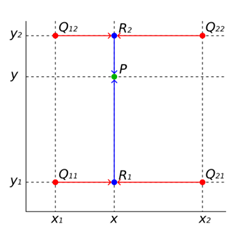

Then given a query x0, y0, the interpolation algorithm shall calculate the interped value.

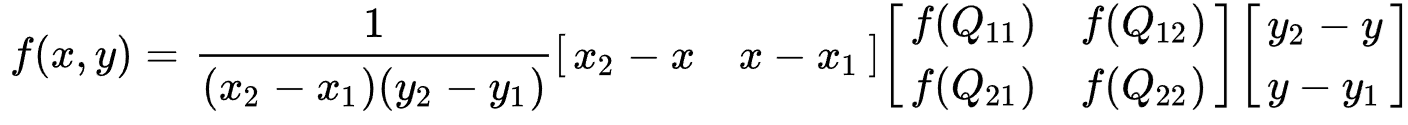

For your information, here is a simple forloop implementation.

In [61]:
#@title Reference implementation.

def interp2d_forloop(
    v: torch.Tensor,
    x_ref_list: torch.Tensor,
    y_ref_list: torch.Tensor,
) -> torch.Tensor:
  # We need to do input check, but here I deliberately skip it.
  h, w = v.shape
  nlen = x_ref_list.shape[0]
  v_ref = torch.zeros(nlen, dtype=torch.float32)

  for i in range(nlen):
    x_ref = x_ref_list[i]
    y_ref = y_ref_list[i]
    x1 = int(max(math.floor(x_ref), 0))
    y1 = int(max(math.floor(y_ref), 0))
    x2 = int(min(x1 + 1, w - 1))
    y2 = int(min(y1 + 1, h - 1))
    dx2 = x2 - x_ref
    dx1 = 1 - dx2
    dy2 = y2 - y_ref
    dy1 = 1 - dy2
    f11 = v[y1, x1]
    f12 = v[y1, x2]
    f21 = v[y2, x1]
    f22 = v[y2, x2]
    v_ref[i] = (f11 * dy2 * dx2 + f12 * dy2 * dx1  +
                f21 * dy1 * dx2 + f22 * dy1 * dx1)
  return v_ref

Now, it is your turn. Implement it using pytorch, but without using forloop.

In [62]:
from os import XATTR_CREATE
#@title Q2.1. interp2d_nofor

def interp2d_nofor(
    v: torch.Tensor,
    x_ref_list: torch.Tensor,
    y_ref_list: torch.Tensor,
) -> torch.Tensor:
  """
  Implement interp2d using python, without forloop and using 3rd-party library.

  Args:
    v: value matrix, which defines v(x, y). x and y are grid points. 2D tensor.
    x_ref: list of x where to grap interpolated value. 1D tensor.
    y_ref: list of y where to grap interpolated value. 1D tensor.

  Returns:
    Interpolation results. 1D tensor
  """
  #### Your code goes here
  h, w = v.shape

  if (v.dim() != 2 or x_ref_list.dim() != 1 or y_ref_list.dim() != 1
      or x_ref_list.size(0) != y_ref_list.size(0)):
    return None

  x_clamp = torch.clamp(x_ref_list, 0)
  y_clamp = torch.clamp(y_ref_list, 0)

  x1 = torch.floor(x_clamp).to(int)
  y1 = torch.floor(y_clamp).to(int)

  x2 = torch.clamp(x1 + 1, max = w - 1)
  y2 = torch.clamp(y1 + 1, max = h - 1)

  dx2 = x2 - x_ref_list
  dx1 = 1 - dx2
  dy2 = y2 - y_ref_list
  dy1 = 1 - dy2

  f11 = v[y1, x1]
  f12 = v[y1, x2]
  f21 = v[y2, x1]
  f22 = v[y2, x2]

  v_ref = (f11 * dy2 * dx2 + f12 * dy2 * dx1  +
                f21 * dy1 * dx2 + f22 * dy1 * dx1)
  return v_ref


**Testing**

Please do run this block before submission, but do not change it. If you change it, you will get no mark for this question.

In [63]:
#@title Test 1

torch.manual_seed(1234)

h_test_list = []
h = 100
w = 50
vlen = 30
v = torch.rand(h, w).to(torch.float32)
x = torch.linspace(0, w-1, w)
y = torch.linspace(0, h-1, h)

interp = scipy.interpolate.RegularGridInterpolator(
    (y.numpy(), x.numpy()), v.numpy(), method='linear')
x_ref = torch.rand(vlen) * (w - 1)
y_ref = torch.rand(vlen) * (h - 1)
xy_ref = np.stack((y_ref.numpy(), x_ref.numpy()), axis=1)
v_ref = interp(xy_ref)

v_ref_forloop = interp2d_forloop(v, x_ref, y_ref)
v_ref_nofor = interp2d_nofor(v, x_ref, y_ref)

assert is_same_tensor(torch.tensor(v_ref), v_ref_forloop, tol=1e-2)
assert is_same_tensor(torch.tensor(v_ref), v_ref_nofor, tol=1e-2)
print('test succeeds')

test succeeds


In [64]:
#@title Test 2

v = torch.rand(10, 4)
x_ref = torch.tensor([2])
y_ref = torch.tensor([2, 4])
assert interp2d_nofor(v, x_ref, y_ref) == None

v = torch.rand(10, 4)
x_ref = torch.tensor([[2, 3], [3, 4]])
x_ref = torch.tensor([[2, 3], [3, 4]])
assert interp2d_nofor(v, x_ref, y_ref) == None

print('test succeeds')

test succeeds
